In [1]:
pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4f/d7/3303f11188122f66c940056f162d030992e7fbc9c702869bab163e85156b/matplotlib-3.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/d8/23/8d968922459b1c8a2c6ffca28fac00324b06b3a0633be2a39b0b1c3f84ab/contourpy-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/2c/35/5f4407acb9658fe93de10ac7998b22617c23ee9b51dada779cd9b66cfe99/fonttools-4.41.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 25.4 MB/s eta 0:00:00
   ━━━

In [2]:
import torch
import os.path

In [18]:
c_g = torch.load("../data/control_variates/control_variates_global_r22.pt")
c_l = torch.load("../data/control_variates/control_variates_c0_r22.pt")

In [1]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [77]:
def load_if_exists(path):
    total_path = f"../data/control_variates/{path}"
    if os.path.exists(total_path):
        return torch.load(total_path, map_location="cpu")
    else:
        return None


variates = [[load_if_exists(f"control_variates_c{client}_r{round}.pt") for client in range(0,10)] for round in range(0,100)]
c_g = [load_if_exists(f"control_variates_global_r{round}.pt")  for round in range(0,100)]

In [121]:
def trySum(a, b):
    if a is None or b is None:
        return None
    else:
        return ((a-b)**2).sum()

def tryMean(a,b):
    if a is None or b is None:
        return None
    else:
        comp = torch.stack([((global_layer-local_layer)**2).sum().sqrt() for (global_layer,local_layer) in zip(a, b)]).mean()
        return comp

diffs = [[tryMean(g, c_l) for c_l in c_ls] for (g, c_ls) in zip(c_g, variates)]
offset_diffs = [[tryMean(c_g[i], c_l) for c_l in variates[i+1]] for i in range(0,98)]

In [122]:
diffPerRound = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in diffs]
max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in diffs]
offset_diff_mean = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in offset_diffs]
offset_max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in offset_diffs]

In [123]:
offset_diff_mean

[0.7310591340065002,
 0.895144522190094,
 0.9322323799133301,
 0.6374154090881348,
 0.7960445880889893,
 0.7033488750457764,
 0.6843039989471436,
 0.6746861934661865,
 1.2071062326431274,
 0.7149462699890137,
 1.0662083625793457,
 0.8229856491088867,
 0.6972401738166809,
 0.3747929334640503,
 0.5531959533691406,
 0.9749765396118164,
 0.40487760305404663,
 1.2773493528366089,
 0.7292432188987732,
 0.5316351652145386,
 0.48376768827438354,
 0.6232898831367493,
 0.5371679067611694,
 0.5309766530990601,
 0.3852135241031647,
 0.8959677219390869,
 0.45713067054748535,
 1.444394826889038,
 0.8882113695144653,
 0.5604596734046936,
 3.055518865585327,
 7.225100040435791,
 1.5442578792572021,
 1.467594027519226,
 1.458723783493042,
 1.4100110530853271,
 1.436028003692627,
 1.4509468078613281,
 1.5205678939819336,
 1.5650708675384521,
 1.4666314125061035,
 1.7794725894927979,
 1.5246601104736328,
 1.4678966999053955,
 2.4815175533294678,
 0.6836432218551636,
 0.5410205125808716,
 0.67341005802154

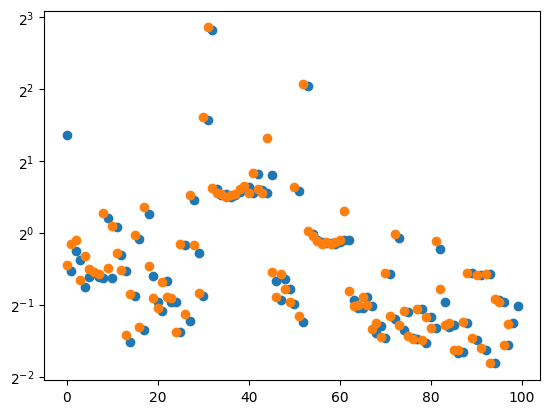

In [131]:
import matplotlib.pyplot as plt

plt.yscale('log',base=2) 
plt.scatter(range(0,100), diffPerRound)
plt.scatter(range(0,98), offset_diff_mean)
plt.show()

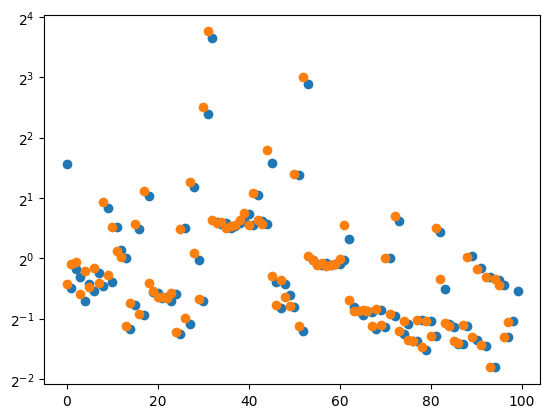

In [133]:
plt.yscale('log',base=2)
plt.scatter(range(0,100), max_dif)
plt.scatter(range(0,98), offset_max_dif)
plt.show()

In [44]:
[c.shape for c in c_g]

[torch.Size([6, 1, 5, 5]),
 torch.Size([6]),
 torch.Size([16, 6, 5, 5]),
 torch.Size([16]),
 torch.Size([120, 256]),
 torch.Size([120]),
 torch.Size([84, 120]),
 torch.Size([84]),
 torch.Size([10, 84]),
 torch.Size([10])]

In [71]:
diff = [((l-g)**2).sum() for l,g in combo]
[t.shape for t in diff]


[torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([])]

In [64]:
diff[9].data

tensor(0.0034, device='cuda:6')